<a href="https://colab.research.google.com/github/praveentn/MidcurveNN/blob/master/notebook_cnn_autoencoder_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN ENC-DEC

In [1]:
# mount google drive & set working directory
# requires auth (click on url & copy token into text box when prompted)
from google.colab import drive
drive.mount("/content/gdrive")

import os
print(os.getcwd())

os.chdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam,RMSprop,SGD
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,AveragePooling2D,UpSampling2D
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from random import shuffle
import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

Using TensorFlow backend.


In [3]:
# working directory
wdir = os.getcwd()
wdir

'/content/gdrive/My Drive/Colab Notebooks/MidcurveNN'

In [212]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = wdir + "/data/input"
input_data_folder = wdir + "/data/9shapes"
print("input data dir: ", input_data_folder)

input data dir:  /content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/9shapes


In [215]:
import glob

image_paths = glob.glob(input_data_folder + '/**/*.png', recursive=True)
images = [os.path.basename(img_path) for img_path in image_paths]

print(len(images))

#images = os.listdir(input_data_folder)
images[99]

2016


'Iuvw_Midcurve_mirrored_1_rotated_30.png'

In [0]:
# image dimension
imdim = 100

In [0]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [0]:
def get_training_data(datafolder=input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [227]:
profile_pngs_objs = ()
midcurve_pngs_objs = ()
shapes = ["CapI", "InvV", "Iuvw", "Luvw", "Plus", "Sm_n", "SqLu", "Tuvw", "Vuvw", ]

for shape in shapes:
    print(shape)
    tp, tm = get_training_data(os.path.join(input_data_folder, shape))
    profile_pngs_objs += tp
    midcurve_pngs_objs += tm
    print(len(profile_pngs_objs), len(midcurve_pngs_objs))

CapI
112 112
InvV
224 224
Iuvw
336 336
Luvw
448 448
Plus
560 560
Sm_n
672 672
SqLu
784 784
Tuvw
896 896
Vuvw
1008 1008


In [228]:
len(profile_pngs_objs)

1008

In [229]:
profile_pngs_objs[0].shape

(100, 100)

In [230]:
type(midcurve_pngs_objs)

tuple

In [0]:
def plot_results(original_imgs,computed_imgs,n=10):
    # n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

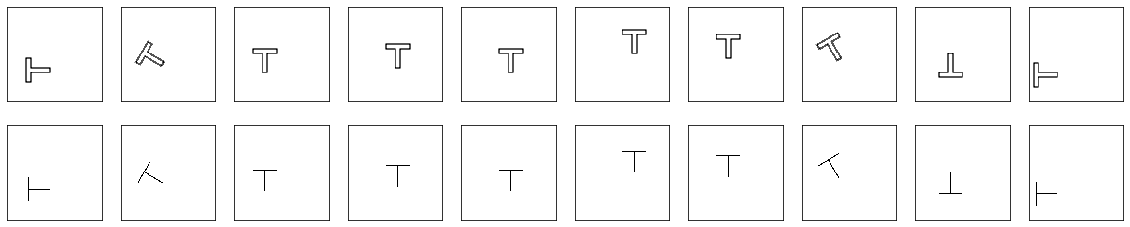

In [232]:
plot_results(profile_pngs_objs[830:850],midcurve_pngs_objs[830:850])

In [0]:
def get_train_test_split(profile_pngs_gray_objs, midcurve_pngs_gray_objs, encoding_dim=imdim, input_dim=imdim):

    # Training
    profile_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in profile_pngs_gray_objs]
    midcurve_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in midcurve_pngs_gray_objs]
    
    profile_pngs_objs = np.array(profile_pngs_flat_objs)
    midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
    
    '''
    train_size = int(len(profile_pngs_objs)*0.7)
    x_train = profile_pngs_objs[:train_size]
    y_train = midcurve_pngs_objs[:train_size]
    x_test = profile_pngs_objs[train_size:]
    y_test = midcurve_pngs_objs[train_size:]
    '''
    x_train, x_test, y_train, y_test = train_test_split(profile_pngs_objs, midcurve_pngs_objs, 
                                                        test_size=0.2, random_state=37)
    return x_train, x_test, y_train, y_test

In [234]:
x_train, x_test, y_train, y_test = get_train_test_split(profile_pngs_objs, midcurve_pngs_objs)

print((len(x_train), len(y_train)), (len(x_test), len(y_test)))

(806, 806) (202, 202)


### Auto-encoder

In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = imdim
        self.img_cols = imdim
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.0005)
        optimizer = SGD(lr=0.0007, nesterov=False)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 25, 25, 32)        9248      
_________________________________________________________________
up_sampling2d_74 (UpSampling (None, 50, 50, 32)        0         
__________

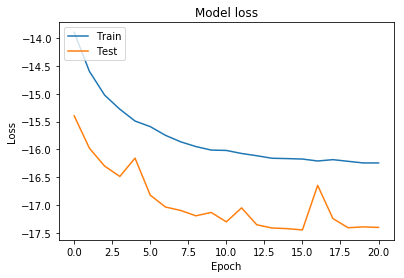

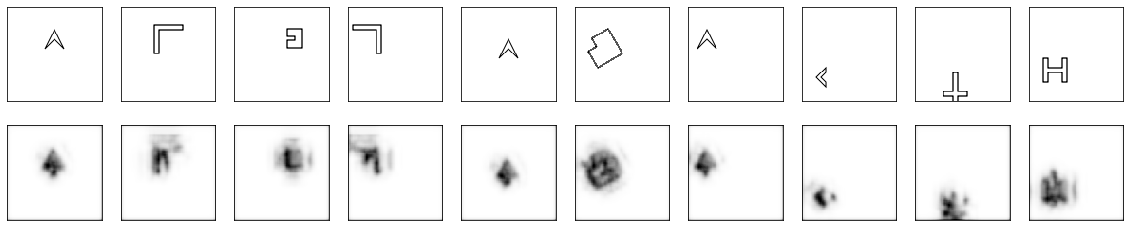

In [242]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_test, y_test, epochs=200, batch_size=5)

encoded_imgs = ae.eval_model(x_test)
decoded_imgs = ae.eval_model(encoded_imgs)

plot_results(x_test, decoded_imgs)